# Face Recognition

In [1]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
from scipy import io as sp
import dlib
import os
import pixiedust
colors = sns.color_palette()

Pixiedust database opened successfully


### Load celebrity name data

In [2]:
celebName = pd.read_csv('Top1M_MidList.Name.tsv',names=['Id','Name'], delimiter='\t', error_bad_lines=False)
language = celebName['Name'].str.split("@", n=1, expand=True)
celebName['Name'] = language[0]
celebName['Language'] = language[1]
celebName = celebName[celebName['Language'] == 'en']
celebName.drop(columns=['Language'], inplace=True)

### Load celebrity images

In [4]:
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)

### Join on id

In [5]:
clebs = clebs.merge(celebName, how='left', left_on='Id', right_on='Id')
del celebName

In [6]:
clebs.head()

,Id,Image,Name
0,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
1,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
2,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
3,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
4,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon


### Data distribution

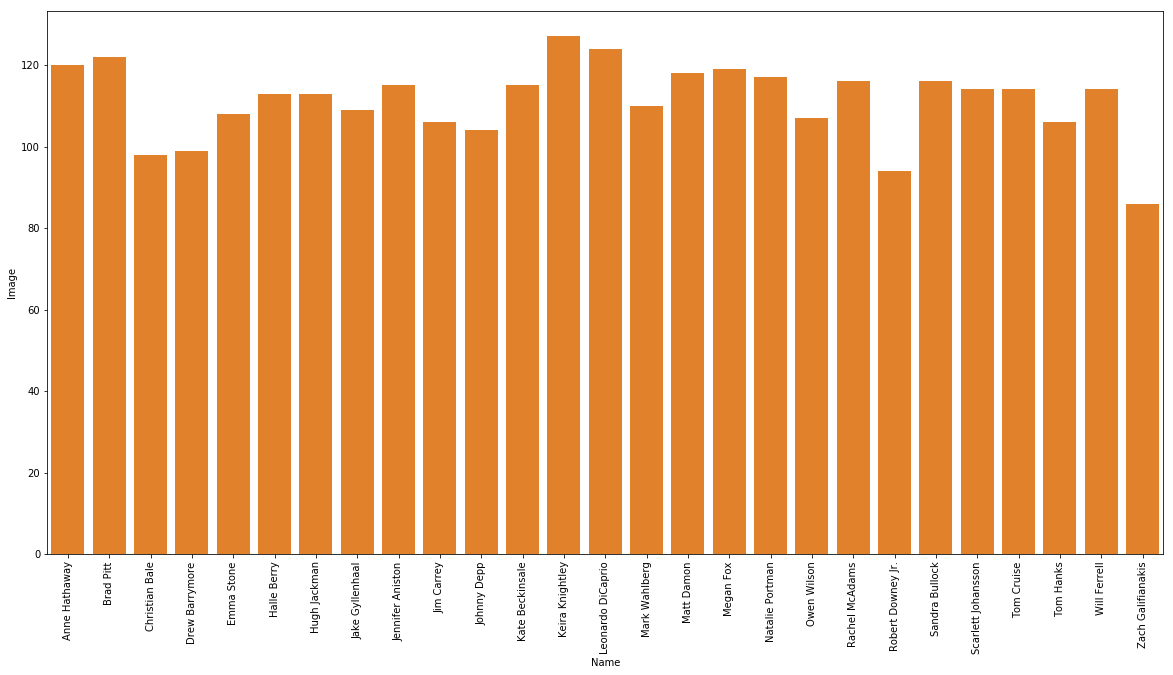

In [7]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

In [8]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

# TODO

In [9]:
def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

In [10]:
def detect_faces(test_image, display=True, scaleFactor = 1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(test_image, 1)
    
    if display:
        image_copy = test_image.copy()
        for rect in faces_rect:
            (x,y,w,h) = rect_to_cordinate(rect)
            cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

In [11]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [12]:
def detect_landmarks(image, faces, display=True):
    pose_landmarks = None
    face_pose_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    
    if display:
        test_copy = image.copy()
    
    for face in faces:
        pose_landmarks = face_pose_predictor(image, face)
        if display:
            for (x, y) in shape_to_np(pose_landmarks):
                cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    
    return pose_landmarks

In [13]:
def scale_face(image, landmarks, display=True):
    fod = dlib.full_object_detections()
    fod.append(landmarks)
    img = dlib.get_face_chips(image, fod, size=128)
    if display:
        for x in img:
            plt.figure(figsize=(8,8))
            plt.imshow(convertToRGB(x))
    return img

In [41]:
def get_scaled(base64image,display=False):
    img_raw = get_opencv2_image(base64image)
    faces = detect_faces(img_raw,display=False)
    if not faces:
        return np.nan
    landmarks = detect_landmarks(img_raw, faces,display=False)
    scaleimg = scale_face(img_raw, landmarks, display=display)
    return scaleimg[0]


### Detect Faces

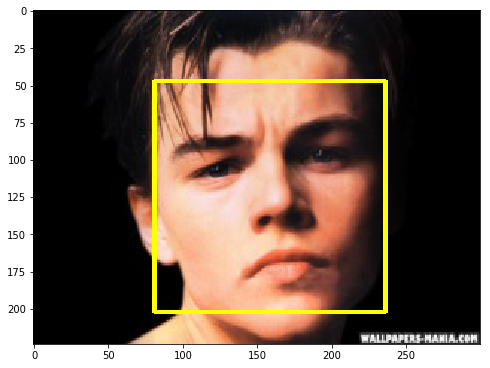

In [24]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

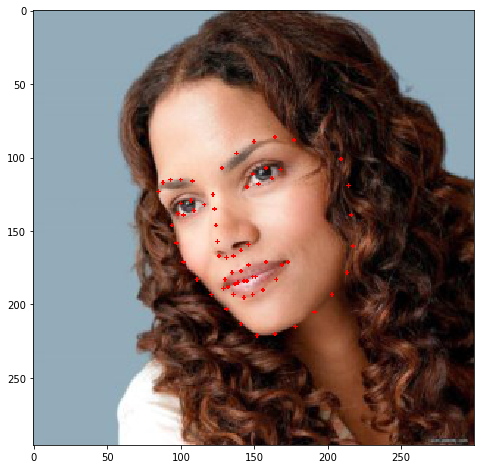

In [23]:
landmarks = detect_landmarks(img_raw, faces)

# Scale And Align Images

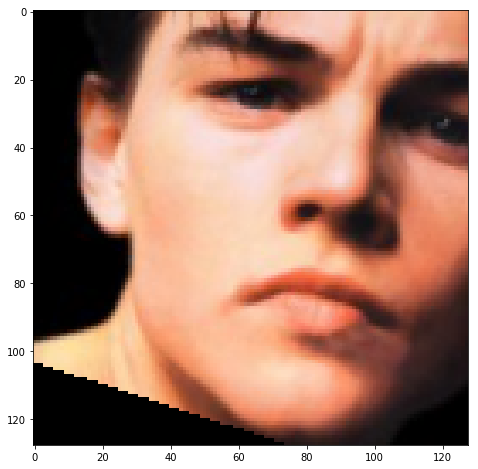

In [25]:
scaleimg = scale_face(img_raw, landmarks, display=True)

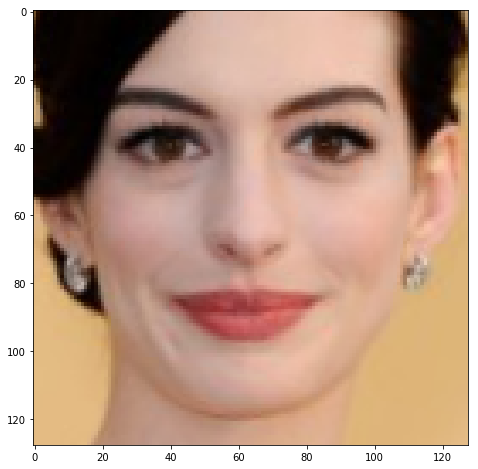

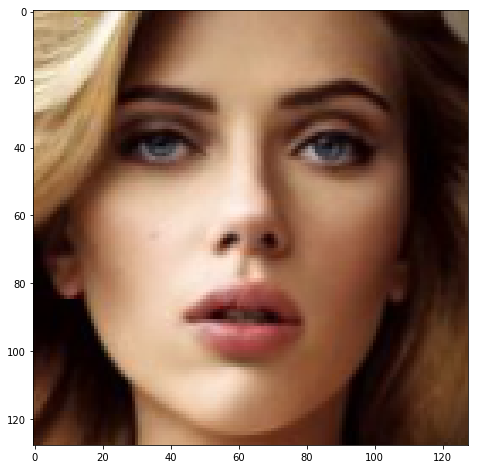

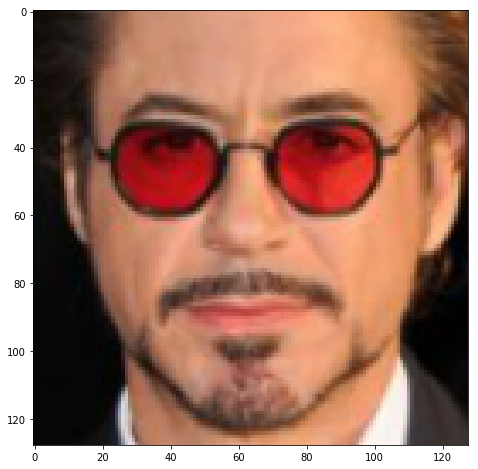

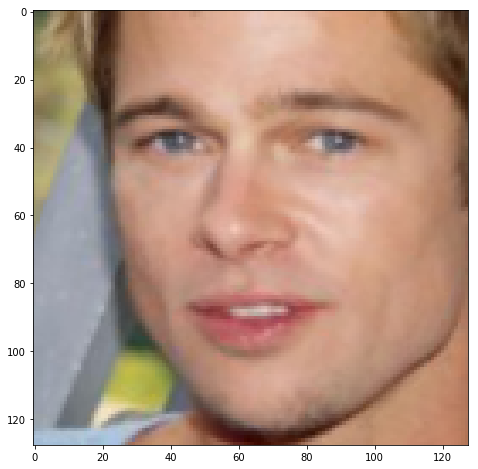

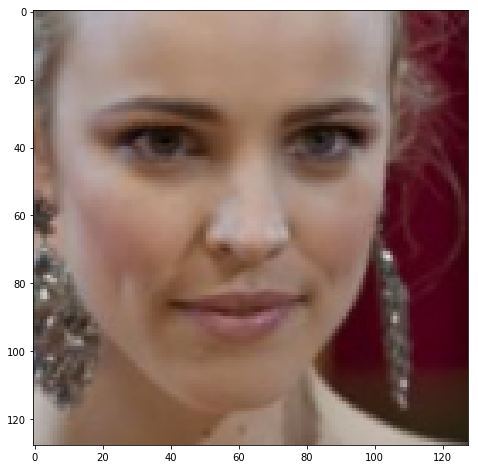

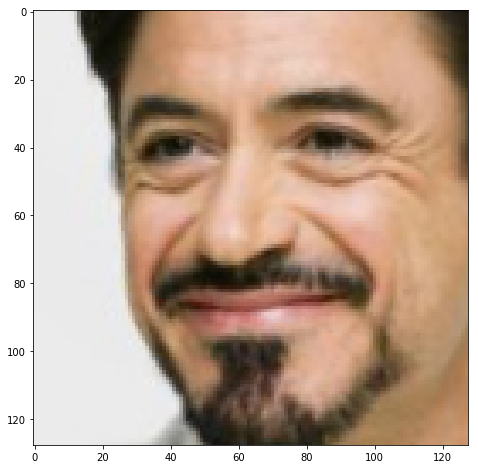

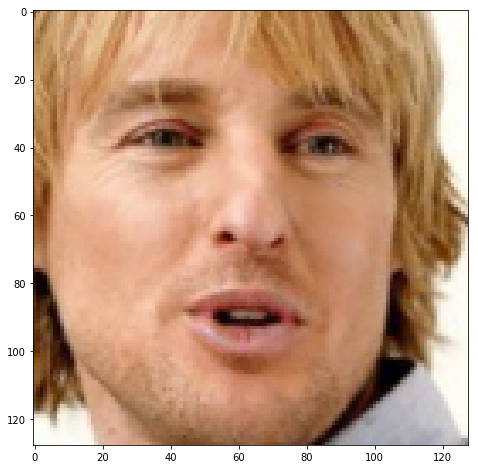

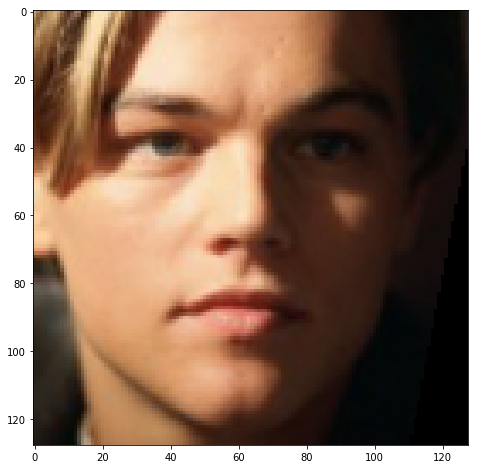

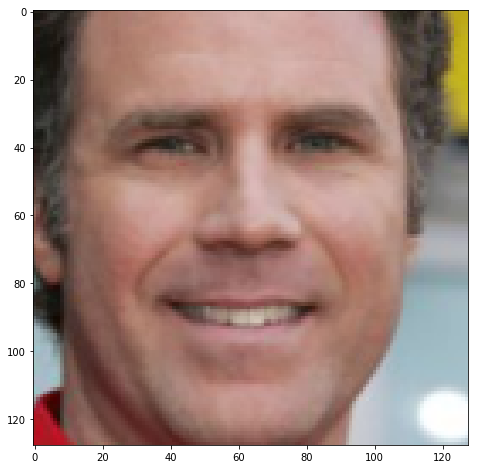

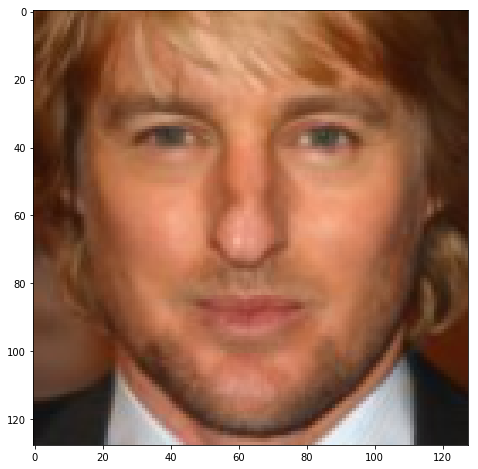

In [30]:
for i in range(10):
    j = rand.randrange(0,len(clebs))
    x = get_scaled(clebs.iloc[j]['Image'],display=True)

In [ ]:
groupedList = clebs.groupby(['Name'])['Image'].apply(list).to_dict()

In [ ]:
clebs['Image'] = clebs['Image'].apply(lambda x: get_scaled(x))

In [ ]:
clebs.head()

In [ ]:
df = clebs.drop(columns=['Name'])
import itertools as it
labels = df.Id.unique()
all_combos = []
for l in labels:
    combos_positive = list(it.combinations(df.loc[df.label == l].as_matrix(), 2))
    combos_negative = list(it.combinations(df.loc[df.label != l].as_matrix(), 2))
    all_combos += combos_positive
    all_combos += combos_negative 
    
print(len(all_combos))

In [ ]:
for image in all_combos[0]:
    get_image(image)

In [ ]:
groupedList = clebs.groupby(['Name'])['Image'].apply(list)
labels = groupedList.keys()
values = groupedList.values
images = [0] * len(values)
for i in range(len(values)):
    scaledImages[i] = [0] * len(values[0])
    print("{}/{} in progress".format(i,len(values)))
    for j in range(15):
        
        scaledImages[i][j] = 
        
# Code to write in file
# for i in range(len(values)):
#     print("{}/{} in progress".format(i,len(values)))
#     os.mkdir('clean/{}'.format(labels[i]))
#     for j in range(len(values[i])):
#         file = 'clean/{}/{}.png'.format(labels[i],j)
#         print(file)
#         scaled = get_scaled(values[i][j])
#         cv2.imwrite(file, cv2.cvtColor(scaled, cv2.COLOR_RGB2BGR))   

In [ ]:
labels = groupedList.keys().values.tolist()

In [ ]:
scaledImages[0][0]

In [ ]:
dt = {}
dt['images'] = scaledImages
dt['labels'] = labels
sp.savemat('dataset', dt)

In [ ]:
dataset = sp.loadmat('dataset')
X = dataset['images']
y = dataset['labels']

In [ ]:
total_sample = 15 * 7 * 27
total_pair = 2
x,y,z = X[0][0].shape

positive_pair = np.zeros((total_sample, total_pair, x, y, z), dtype=float)
counter = 0
for i in range(len(X)):
    for j in range(0, len(X[0]) - 1):
        for k in range(j+1, len(X[0])):
            positive_pair[counter][0] = X[i][j]
            positive_pair[counter][1] = X[i][k]
            counter = counter + 1
positive_cost = np.full((total_sample,1), 1)

In [ ]:
total_negative_per_point = 30
total_sample = 15 * 27 * total_negative_per_point
total_pair = 2
x,y,z = X[0][0].shape

negative_pair = np.zeros((total_sample, total_pair, x, y, z), dtype=float)
counter = 0

for i in range(len(X)):
    for j in range(len(X[0])):
        for k in range(total_negative_per_point):
            p1 = rand.randrange(0, len(X))
            while p1 == i:
                p1 = rand.randrange(0, len(X))
            p2 = rand.randrange(0, len(X[0]))
            negative_pair[counter][0] = X[i][j]
            negative_pair[counter][0] = X[p1][p2]
            counter = counter + 1
negative_cost = np.full((total_sample, 1), 0)